# London Bike Share Analysis


The **goal** of this analysis is to determine and evaluate **the key factors** associated with **bike share ride** volume.

By examining variables such as time of day, weather conditions, and day type, this analysis explores patterns that can help improve how bike services are managed and planned.

## Table of contents

- 1. [Introduction](#1.-Introduction)
- 2. [Data Loading and Overview](#2.-Data-Loading-and-Overview)
- 3. [Data Cleaning](#3.-Data-Cleaning)
- 4. [Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))
- 5. [Feature Engineering](#5.-Feature-Engineering)
- 6. [Statistical Analysis](#6.-Statistical-Analysis)
    - 6.1 [Pearson correlation coefficient](#6.1-Pearson-correlation-coefficient)
    - 6.2 [One-Way ANOVA](#6.2-One-Way-ANOVA)
        - 6.2.1 [Seasonal differences in bike rides](#6.2.1-Seasonal-differences-in-bike-rides)
        - 6.2.2 [Bike Ride Differences by Day Type (Working vs. Non-working)](#6.2.2-Bike-Ride-Differences-by-Day-Type-(Working-vs.-Non-working))
    - 6.3 [Mann-Whitney U Test: Bike Ride Differences by Day Type](#6.3-Mann-Whitney-U-Test:-Bike-Ride-Differences-by-Day-Type)
    - 6.4 [Kruskal-Wallis Test: Bike Rides by Weather Condition](#6.4-Kruskal-Wallis-Test:-Bike-Rides-by-Weather-Condition)
- 7. [Conclusion](#7.-Conclusion)
- [Appendix: Robustness check (not included in main analysis)](#Appendix:-Robustness-check-(not-included-in-main-analysis))

## 1. Introduction

![Greeting Quotation Image](Quotation_image_1.jpg)

Bike sharing has become a popular transportation option in major cities like London, helping to reduce traffic and air pollution. 

**The hypothesis** is that bike sharing demand in London depends strongly on weather, time of day, day type and seasonal trends.

### Metadata:  
"timestamp" - timestamp field for grouping the data<br>
"cnt" - the count of new bike shares<br>
"t1" - real temperature in C<br>
"t2" - temperature in C "feels like"<br>
"hum" - humidity in percentage<br>
"wind_speed" - wind speed in km/h<br>
"weather_code" - category of the weather<br>
"is_holiday" - boolean field - 1 holiday / 0 non holiday<br>
"is_weekend" - boolean field - 1 if the day is weekend<br>
"season" - category field meteorological seasons:<br>
- 0-spring ;<br>
- 1-summer;<br>
- 2-autumn;<br>
- 3-winter.<br>

"weathe_code" category description:<br>
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity<br>
2 = Scattered clouds / Few clouds<br>
3 = Broken clouds<br>
4 = Cloudy<br>
7 = Rain/ Light Rain shower/ Light rain<br>
10 = Rain with thunderstorm<br>
26 = Snowfall<br>
94 = Freezing Fog<br>


The data used in this analysis was originally gathered from the following sources:

- **Transport for London (TfL) Open Data Portal** — https://cycling.data.tfl.gov.uk  
  *Bike sharing usage data*  
  **Powered by TfL Open Data**  
  Contains OS data © Crown copyright and database rights 2016  
  Geomni UK Map data © and database rights [2019]

- **FreeMeteo** — https://freemeteo.com  
  *Hourly historical weather data for London*

- **UK Government** — https://www.gov.uk/bank-holidays  
  *Official bank holidays in the UK (England)*

The final version of the dataset used in this project was preprocessed (merged, cleaned, and aggregated by hour) and published by a Kaggle user:  
**https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset**

The official data for bike sharing contains "Start date" and "End Date" columns, for the calculations the trips are grouped by "Start date" column for every hour.

## 2. Data Loading and Overview

In [2]:
# import and/or install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
from scipy import stats
#install scikit-posthocs if needed
#!pip install scikit-posthocs
import scikit_posthocs as sp
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import tukey_hsd
from scipy.stats import kruskal

In [3]:
# read in the csv file as a pandas dataframe
bikes = pd.read_csv("london_merged.csv")

In [4]:
# explore the data
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


***
The **'timestamp'** column is currently stored as an object type and needs to be converted to **datetime** for further analysis.
***

In [5]:
# check the rows and colums count
bikes.shape

(17414, 10)

In [6]:
# view the data set
bikes

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


***
Variables 'weather_code', 'is_holiday', 'is_weekend' and 'season' are stored as **numeric**, but represent **categorical** data.
***

In [7]:
bikes.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [8]:
# count the unique values in the weather_code column
bikes.weather_code.value_counts()

weather_code
1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: count, dtype: int64

***
Not all the weather categories are present in the count. As there is **no observations** for the weather code **"94 = Freezing  Fog"**, it will be removed while renaming the values.

Categories 10.0 and 26.0 have extremely **low sample sizes**, they represent intense weather events such as rain with thunderstorm or snowfall and will be grouped together during data cleaning.

***

In [9]:
# count the unique values in the season column
bikes.season.value_counts()

season
0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: count, dtype: int64

## 3. Data Cleaning

### Column Renaming

In the next step, the columns will be **renamed** to improve readability. Also units of measurements will be added for easier interpretation.

In [10]:
# specify the new column names
new_cols_dict ={
    'timestamp':'time',
    'cnt':'count', 
    't1':'temp_real_C',
    't2':'temp_feels_like_C',
    'hum':'humidity_percent',
    'wind_speed':'wind_speed_kph',
    'weather_code':'weather',
    'is_holiday':'is_holiday',
    'is_weekend':'is_weekend',
    'season':'season'
}

# rename the columns to the specified column names
bikes.rename(new_cols_dict, axis=1, inplace=True)

### Decoding Categorical Values

Currently, categorical variables such as **weather** and **season** are stored as numeric codes which are convenient for analysis and visualization.

To improve readability these codes will be replaced with meaningfull labels.

In [11]:
# create a season dictionary to map the integers 0-3 to the actual written values readability and future analysis
season_dict = {
    '0.0':'spring',
    '1.0':'summer',
    '2.0':'autumn',
    '3.0':'winter'
}

# create a weather dictionary to map the integers to the actual written values for future visualizations and analysis
# remove the code '94.0 : 'Freezing Fog', because there is no corresponding observations
# group the last 2 weather codes into 'Heavy precipitation' group, to ensure sufficient sample size
weather_dict = {
    '1.0':'Clear',
    '2.0':'Scattered clouds',
    '3.0':'Broken clouds',
    '4.0':'Cloudy',
    '7.0':'Rain',
    '10.0':'Heavy precipitation',
    '26.0':'Heavy precipitation'
}

# change the seasons column data type to string
bikes.season = bikes.season.astype('str')
# map the values 0-3 to the actual written seasons
bikes.season = bikes.season.map(season_dict)

# change the weather column data type to string
bikes.weather = bikes.weather.astype('str')
# map the values to the actual written weather names
bikes.weather = bikes.weather.map(weather_dict)

### Hour Column Addition

To analyze the dynamics of bike share rides during the day, the hour will be extracted from the `'timestamp'` column and stored as a new column called `'hour'`.

In [12]:
# change column type to a pandas datetime object
bikes['time']=pd.to_datetime(bikes['time'])

# create the new 'hour' column to later check bike rides distribution by hour
bikes['hour']=bikes['time'].dt.hour

### Workday Column Addition

Currently, there are 2 columns, `'is_holiday'` and `'is_weekend'` that indicate the type of day. While these can be combined to  identify workdays, repeating this logic during analysis and visualisation process is impractical. To adress this, new column - `'is_workday'` - will be created.

Additionally, new column and the original day-type columns will be converted from float to integer type to better reflect their categorical nature and improve consistency.

In [13]:
# add column with workdays and non-workdays
bikes.loc[(bikes['is_weekend'] == 0) & (bikes['is_holiday'] == 0), 'is_workday'] = 1
bikes.loc[(bikes['is_weekend'] == 1) | (bikes['is_holiday'] == 1), 'is_workday'] = 0

# change columns type to integer
bikes['is_holiday']=bikes['is_holiday'].astype(int)
bikes['is_weekend']=bikes['is_weekend'].astype(int)
bikes['is_workday']=bikes['is_workday'].astype(int)

In [14]:
# check the dataframe to see if the mappings have worked
bikes.head()

,time,count,temp_real_C,temp_feels_like_C,humidity_percent,wind_speed_kph,weather,is_holiday,is_weekend,season,hour,is_workday
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,Broken clouds,0,1,winter,0,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,Clear,0,1,winter,1,0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,Clear,0,1,winter,2,0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,Clear,0,1,winter,3,0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,Clear,0,1,winter,4,0


## 4. Exploratory Data Analysis (EDA)

Before diving into deeper analysis, it is important to understand the distribution of bike share rides relative to other variables such as temperature, humidity, weather, hour of the day, day type, season and month of the year.

The next step will contain summary statistics to reveal the central tendencies, variability and potential outliers in the data.

This step will be followed by visual analysis of ditributions and identification of the most common values.

In [15]:
# generate descriptive statistics
bikes.describe().T

,count,mean,min,25%,50%,75%,max,std
time,17414,2016-01-03 22:31:00.571953664,2015-01-04 00:00:00,2015-07-04 20:15:00,2016-01-03 15:30:00,2016-07-04 15:45:00,2017-01-03 23:00:00,NaN
count,17414.0,1143.101642,0.0,257.0,844.0,1671.75,7860.0,1085.108068
temp_real_C,17414.0,12.468091,-1.5,8.0,12.5,16.0,34.0,5.571818
temp_feels_like_C,17414.0,11.520836,-6.0,6.0,12.5,16.0,34.0,6.615145
humidity_percent,17414.0,72.324954,20.5,63.0,74.5,83.0,100.0,14.313186
wind_speed_kph,17414.0,15.913063,0.0,10.0,15.0,20.5,56.5,7.89457
is_holiday,17414.0,0.022051,0.0,0.0,0.0,0.0,1.0,0.146854
is_weekend,17414.0,0.285403,0.0,0.0,0.0,1.0,1.0,0.451619
hour,17414.0,11.513265,0.0,6.0,12.0,18.0,23.0,6.915893
is_workday,17414.0,0.692546,0.0,0.0,1.0,1.0,1.0,0.461452


***
**Key findings:**

The **mean value** of the bike share count exceeds the **median**. To explore this difference further, the **second Pearson’s coefficient of skewness (Sk₂)** was calculated and equals to **0.827**, indicating a strong and statistically significant **right-skewed distribution**. This suggests that the data has a **long tail on the right**, and the mean is considerably greater than the median.


The **large gap** between the **75th percentile (1671.75)** and the **maximum value (7860)** in the `'count'` column further supports the presence of a **long right tail**. This may reflect **high-impact events** - specific periods when the number of bike rides **increases dramatically**. These values could represent **seasonal peaks, recurring public events, or data anomalies,** and should be examined in more detail.
***

C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


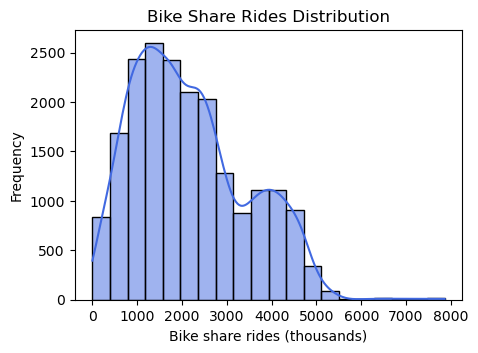

In [16]:
# generate bike share rides distribution
# as the data is aggregated by hours using weights='count' allows each aggregated observation 
# to contribute proportionally to the histogram, it treats each count value as multiple individual events
plt.figure(figsize=(5, 3.5)) 
bike_distr_plot = sns.histplot(data=bikes, x='count', weights='count', stat='count', bins=20, kde=True, color = 'royalblue')

# format y-axis labels to show bike rides in thousands
bike_distr_plot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))


# add axis labels and title
plt.ylabel('Frequency')
plt.xlabel('Bike share rides (thousands)')
plt.title('Bike Share Rides Distribution')

plt.show()

***
**Interpretation:**
* The bike share ride distribution is **positively skewed**. The tail extends toward higher values and represents large number of less frequent bike rides. 
* There is a slight **bimodality** with the second less prominent peak. This suggests the presence of  two different patterns of usage.

**Business insight:**
* The presence of two ride volume peaks may indicate different user types or use cases (e.g. commuting vs. leisure). This can inform targeted pricing or membership plans.
***

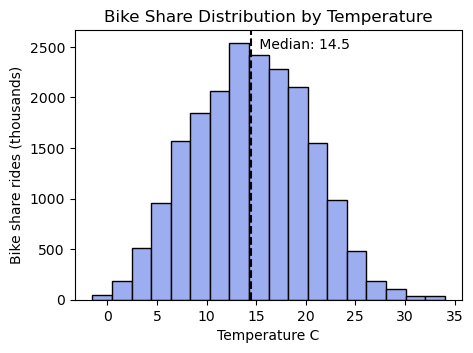

In [17]:
# generate bike share distribution by temperature
# create the figure and axes
# plot the distribution of bike rides by temperature
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.hist(bikes['temp_real_C'], bins=18, weights=bikes['count'], 
        color='#9cadf0', edgecolor='black')

# format y-axis labels to show bike rides in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

# add axis labels and title
ax.set_title('Bike Share Distribution by Temperature')
ax.set_xlabel("Temperature С")
ax.set_ylabel("Bike share rides (thousands)")

# find a weighted median temperature to reduce the risk of errors due to data aggregation
    # sort by temperature(index)
    # compute cumulative sum
    # find the total weight - sum of all bike ride counts
    # calculate the temperature where cumulative sum reaches at least 50% of total
def weighted_median(df, column, count_col='count'):
    rides_sorted = df.groupby(column)[count_col].sum().sort_index()
    cumul_sum = rides_sorted.cumsum()
    total_sum = rides_sorted.sum()
    return cumul_sum[cumul_sum >= total_sum /2].index[0]

temp_weighted_median = weighted_median(bikes, 'temp_real_C')

# add weighted median line and annotation
ax.axvline(temp_weighted_median, color='black', linestyle='--')
ax.text(x=temp_weighted_median + 10, y = ax.get_ylim()[1] * 0.93, s=f' Median: {temp_weighted_median:.1f}', ha='right')

plt.show()

***
**Interpretation:**
* The distribution of bike rides by temperature is **approximately normal** with weighted **median of 14.5 °C**. As the temperature becomes too cold or too hot, the number of trips declines symmetrically. 
* The **most frequent temperature range** is between **10 and 20 °C**, suggesting that moderate weather conditions are the most common for riding.

**Business insight:**
*  Mild temperature peak indicates optimal riding conditions. Seasonal promotions or maintenance schedules can be aligned with expected high-usage temperature.
***

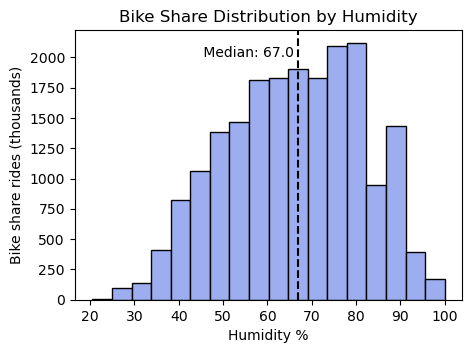

In [46]:
# generate bike share distribution by humidity
# create the figure and axes
# plot the distribution of bike rides by humidity
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.hist(bikes['humidity_percent'], bins=18, weights=bikes['count'], 
        color='#9cadf0', edgecolor='black')

# format y-axis labels to show bike rides in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

# add axis labels and title
ax.set_title('Bike Share Distribution by Humidity')
ax.set_xlabel("Humidity %")
ax.set_ylabel("Bike share rides (thousands)")

# find a weighted median humidity
humid_weighted_median = weighted_median(bikes, 'humidity_percent')

# add weighted median line and annotation
ax.axvline(humid_weighted_median, color='black', linestyle='--')
ax.text(x=humid_weighted_median - 1, y = ax.get_ylim()[1] * 0.90, s=f' Median: {humid_weighted_median:.1f}', ha='right')

plt.show()

***
**Interpretation:**
* Bike share ride distribution across humidity levels folows an **approximately normal distribution**, with a weighted median of 67%. 

* However, there is a slight positive skew with a small number of unusually **high values between 75% and 90%** that deviate from normal pattern. These outliers indicate **irregular usage during high-humidity** conditions.

**Business insight:**
*  Despite high humidity, some riders remain active - possibly commuters or other consistent users. This suggests that full service should be maintained during humid periods, and user segmentation could be tracked to better understand riding behavoir in these conditions.
***

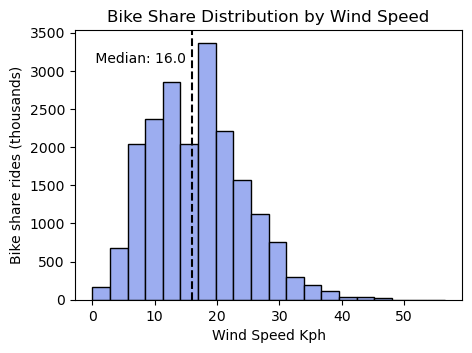

In [19]:
# generate bike share distribution by wind speed
# create the figure and axes
# plot the distribution of bike rides by wind speed
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.hist(bikes['wind_speed_kph'], bins=20, weights=bikes['count'], 
        color='#9cadf0', edgecolor='black')

# format y-axis labels in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

# add axis labels and title
ax.set_title('Bike Share Distribution by Wind Speed')
ax.set_xlabel("Wind Speed Kph")
ax.set_ylabel("Bike share rides (thousands)")

# find a weighted median humidity
wind_weighted_median = weighted_median(bikes, 'wind_speed_kph')

# add weighted median line and annotation
ax.axvline(wind_weighted_median, color='black', linestyle='--')
ax.text(x=wind_weighted_median - 1, y = ax.get_ylim()[1] * 0.88, s=f' Median: {wind_weighted_median:.1f}', ha='right')

plt.show()

***
**Interpretation:**

The distribution is **approximately unimodal** with a **slight positive skew** and a right tail. There is an unexpected local dip in values near the weighted median and a sharp increase in bike rides leading to it, suggesting a subtle deviation from symmetry.

**Business insight:**
*  A steady rise in bike usage with wind speed, followed by a subtle dip, may point to a comfort treshold for riders. Capruting this nuance can improve fine-tuning predictive demand forecasting and support smarter operational decisions.
***

C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

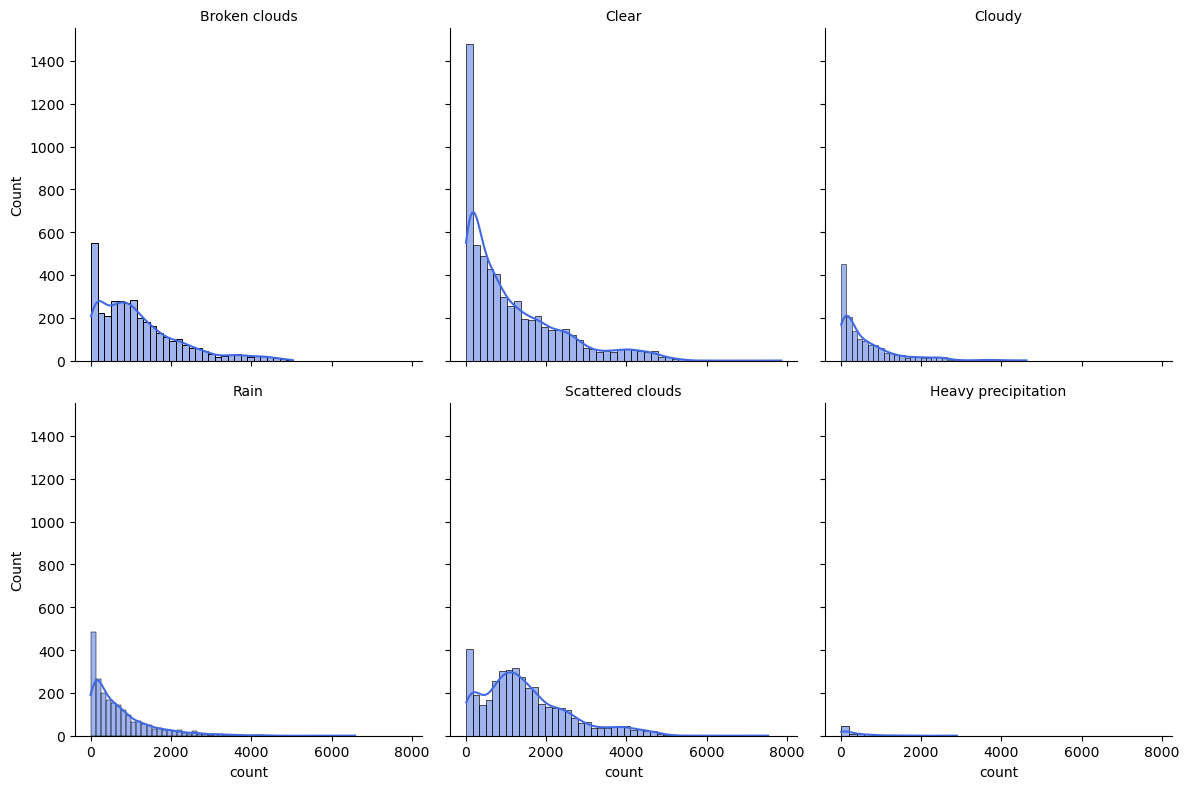

In [20]:
# generate histograms for each weather category
# group by 'weather', set max amount of charts per row to 3 and height of each of them to 4
weather_charts = sns.FacetGrid(bikes, col='weather', col_wrap=3, height=4)

# add bike rides 'count' distribution to each subplot
weather_charts.map(sns.histplot, 'count', kde=True, color = 'royalblue')

# set subplots names
weather_charts.set_titles(col_template="{col_name}")

plt.show()

***
**Interpretation:**

The distributions of bike rides across different weather conditions, as visualized in the histograms, clearly **deviate from normality** with left skewness and a prominent peak near zero, followed by a gradual decline. Heavy precipitation chart shows noticeably less bike ride volume than other weather categories.

**Business insight:**
* Poor weather sharply reduces ride frequency. This trend can inform dynamic pricing models, demand forecasting, or decisions around whether to pause or reduce bike availability on bad weather days.
***

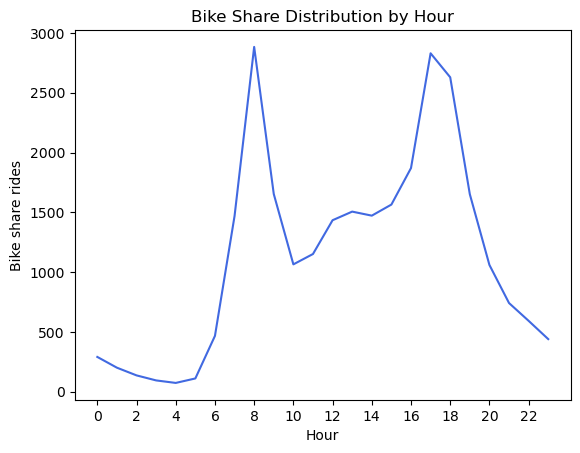

In [21]:
# create bike shares hourly distribution plot to see which hour/hours have the highest amount of bike rides

general_hour_plot = bikes.groupby(by=bikes['hour'])['count'].mean().plot(xticks = range(0, 24, 2), 
                                                                         title='Bike Share Distribution by Hour', 
                                                                         color = 'royalblue')
# set axis names
general_hour_plot.set_xlabel("Hour")
general_hour_plot.set_ylabel("Bike share rides")

plt.show()

In [22]:
# display the peak hours for bike rides

bikes.groupby(by=bikes['hour'])['count'].mean().sort_values(ascending = False).head(5)

hour
8     2882.823204
17    2829.585165
18    2629.043956
16    1869.801370
9     1653.019257
Name: count, dtype: float64

***
**Interpretation:**

The hourly distribution of bike rides shows a pronounced **bimodality**, with distinct peaks around **8:00 and 17:00**. This likely reflects commuting behavior, with increased number of rides before and after typical **working hours**. To further explore this pattern, ride distributions will be compared across different day types: workdays, weekends and holidays.

**Business insight:**

Peak demand during commute hours can be taken into consideration by operators to adjust fleet distribution and pricing to match this daily usage pattern.
***

In [23]:
# divide data set into groups(dataframes) to analyze hourly distribution by day types (workdays, weekends, holidays)

bikes_workdays = bikes[(bikes['is_weekend'] == 0) & (bikes['is_holiday'] == 0)]
bikes_workdays = bikes_workdays.drop(['is_holiday','is_weekend'],axis='columns')

bikes_weekends = bikes[(bikes['is_weekend'] == 1) & (bikes['is_holiday'] == 0)]
bikes_weekends = bikes_weekends.drop(['is_holiday','is_weekend'],axis='columns')

bikes_holidays = bikes[bikes['is_holiday'] == 1]
bikes_holidays = bikes_holidays.drop(['is_holiday','is_weekend'],axis='columns')

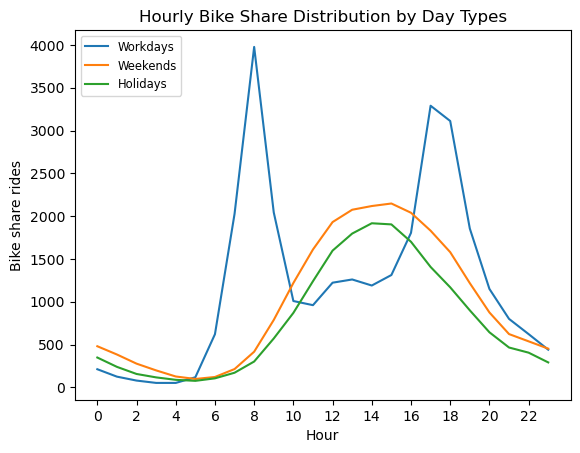

In [24]:
# create function for plotting bike shares by hour arguments: df - pandas dataframe, title - title of the plot

def hourly_plot(df, df_title):
    plot_by_day_types = df.groupby(by=bikes['hour'])['count'].mean().plot(xticks=range(0, 24, 2), title=df_title)
    plot_by_day_types.set_xlabel("Hour")
    plot_by_day_types.set_ylabel("Bike share rides")
    plot_by_day_types.legend(['Workdays','Weekends','Holidays'],loc=2, fontsize = 'small')
    

# check bike rides distribution for each day type with the same title to observe all in one chart

hourly_plot(bikes_workdays, "Hourly Bike Share Distribution by Day Types")
hourly_plot(bikes_weekends, "Hourly Bike Share Distribution by Day Types")
hourly_plot(bikes_holidays, "Hourly Bike Share Distribution by Day Types")

In [25]:
# display the day types sample sizes to assess the possibilities for the future analysis 

for day_type in (bikes_workdays, bikes_weekends, bikes_holidays):
    print(len(day_type))

12060
4970
384


***
**Interpretation**

There is a clear **distinction** between bike ride distributions on **working and non-working** days. 

The distributions for **holidays and weekends** distributions are relatively similar, both showing **unimodality with a peak around midday**.    
In contrast, the distribution for **workdays remains bimodal**, likely contributing the most to the overall hourly distribution due to its larger sample size.

Given the relatively small sample size of the holiday group (384 rides, compared to 12 060 for workdays and 4 970 for weekends) and the observed similarity between holidays and weekends, it appears resonable to combine these two groups in further analysis.

**Business insight:**
* Distinct workday vs. non-workday patterns indicate different user goals (commuting vs. leisure). This can inform marketing segmentation, bike availability, and dynamic pricing strategies by day type.
***

In [26]:
# display the top 5 values for each day time by hour
# create top 5 for each group

weekend_top = bikes_weekends.groupby(by=bikes['hour'])['count'].mean().sort_values(ascending = False).head(5).round(2)
holiday_top = bikes_holidays.groupby(by=bikes['hour'])['count'].mean().sort_values(ascending = False).head(5).round(2)
workday_top = bikes_workdays.groupby(by=bikes['hour'])['count'].mean().sort_values(ascending = False).head(5).round(2)

# combine all groups and name columns by day type

top_combined = pd.concat([weekend_top, holiday_top, workday_top], axis = 1)
top_combined.columns = ['weekends', 'holidays', 'workdays']

# change an index name placing to the same level as the column names

top_combined_reset = top_combined.T.rename_axis("hour", axis = 'columns').rename_axis(None, axis='rows')

print("\nTable 1. Top 5 Peak Hours for Bike Rides by Day Type (Workdays, Weekends, Holidays)")
top_combined_reset


Table 1. Top 5 Peak Hours for Bike Rides by Day Type (Workdays, Weekends, Holidays)


hour,15,14,13,16,12,8,17,18,9,7
weekends,2147.71,2118.17,2074.86,2039.58,1930.78,NaN,NaN,NaN,NaN,NaN
holidays,1903.50,1916.88,1796.38,1700.38,1597.19,NaN,NaN,NaN,NaN,NaN
workdays,NaN,NaN,NaN,NaN,NaN,3977.47,3290.18,3111.72,2042.9,2026.75


**Interpretation:**

In addition to the earlier visualizations, Table 1 summarizes the peak hours and corresponding ride counts for each day type. As expected, the highest number of rides on **workdays** occur during both morning and evening commute times (**7:00–9:00 and 17:00–18:00 hours**), while weekends and holidays show a **single midday peak** between 12:00 and 16:00.


**Business insight:**

Knowing the exact peak hours can help optimize maintenance, and bike redistribution schedules to meet demand without overstocking or under-serving.

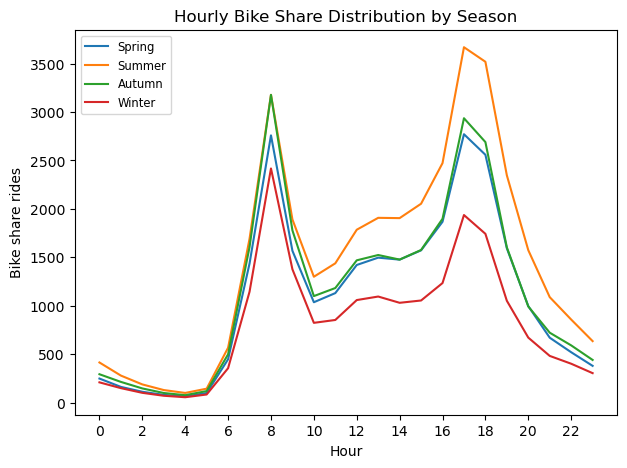

In [27]:
# create dataframes to see if there is a difference between seasons in hourly distribution 
bikes_spring = bikes.loc[bikes['season'] == 'spring']
bikes_summer = bikes.loc[bikes['season'] == 'summer']
bikes_autumn = bikes.loc[bikes['season'] == 'autumn']
bikes_winter = bikes.loc[bikes['season'] == 'winter']

# create function for plotting hourly bike shares by season: df - pandas dataframe, title - title of the plot
def seasonal_plot(df, df_title):
    plot_by_season = df.groupby(by=bikes['hour'])['count'].mean().plot(xticks=range(0, 24, 2), title=df_title, figsize=(7, 5))
    plot_by_season.set_xlabel("Hour")
    plot_by_season.set_ylabel("Bike share rides")
    plot_by_season.legend(['Spring','Summer','Autumn', 'Winter'], loc=2, fontsize = 'small')
    
# plot hourly distribution by seasons
seasonal_plot(bikes_spring, "Hourly Bike Share Distribution by Season")
seasonal_plot(bikes_summer, "Hourly Bike Share Distribution by Season")
seasonal_plot(bikes_autumn, "Hourly Bike Share Distribution by Season")
seasonal_plot(bikes_winter, "Hourly Bike Share Distribution by Season")

***
**Interpretation:**

* **All groups exhibit a similar bimodal distribution**, with two distinct peaks, indicating increased bike usage before and after typical work hours. 

* **In autumn and winter**, the morning peaks are more pronounced than the evening ones, suggesting higher number of bike rides in the early hours. 

* **In spring**, morning and evening hour volumes are relatively balanced. 

* In contrast, **summer** shows a noticeably larger evening peak, indicating that more people prefer to ride bikes in the evenings during this season.

**Business insight:**
* Seasonal time-of-day preferences may reflect weather or lifestyle changes (e.g. longer summer evenings, vacations, holiday seasons). Business can tailor promotions or availability windows based on seasonal behavoir changes.
***

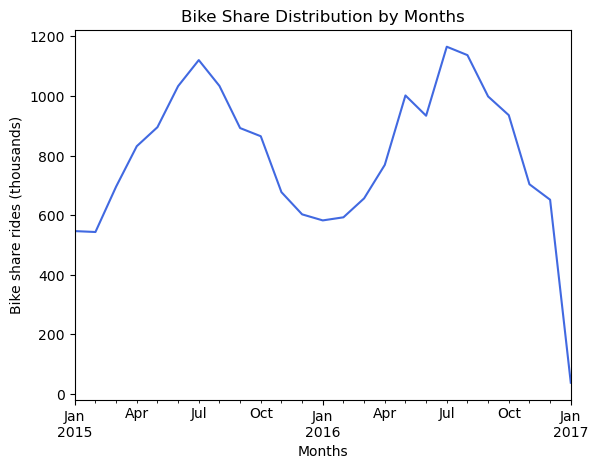

In [28]:
# generate distribution plot of bike rides by months 
monthly_plt = bikes.groupby(by=bikes['time'].dt.to_period("M"))['count'].sum().plot(title='Bike Share Distribution by Months', 
                                                                                    color = 'royalblue')

# format y-axis labels to show bike rides in thousands
monthly_plt.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

# add axis labels and title
monthly_plt.set_xlabel("Months")
monthly_plt.set_ylabel("Bike share rides (thousands)")

plt.show()

In [29]:
# display the top months by bike rides sum

bikes.groupby(by=bikes['time'].dt.to_period("M"))['count'].sum().sort_values(ascending=False).head(8)

time
2016-07    1165527
2016-08    1137314
2015-07    1120687
2015-08    1033951
2015-06    1033252
2016-05    1001935
2016-09     998619
2016-10     935706
Freq: M, Name: count, dtype: int64

***
**Interpretation**

The monthly distribution of bike rides displays a clear cyclical pattern, with the **lowest** number of rides occurring around **January** and the **highest** around **July**. Exact monthly ride totals are shown above, providing the numerical support for the observed trend.

**Business insight**

Strong seasonality suggests that operational planning (e.g. maintenance, marketing, staff allocation) should anticipate summer surges and winter slowdowns.

***
**Aggregation and assumption of independence**

Before further analyzing of seasonal variations in bike rides, it is important to consider the characteristics of the dataset.  

The data in the bikes dataframe is aggregated on an **hourly basis** for each day, which may violate the **assumption of independence** among observations required for certain statistical analyses, such as those assuming normality.   

To address this issue, a higher-level aggregation — such as daily or weekly — can be applied to reduce temporal dependency. Daily aggregation will be applied for this purpose before building Q-Q plots.
***

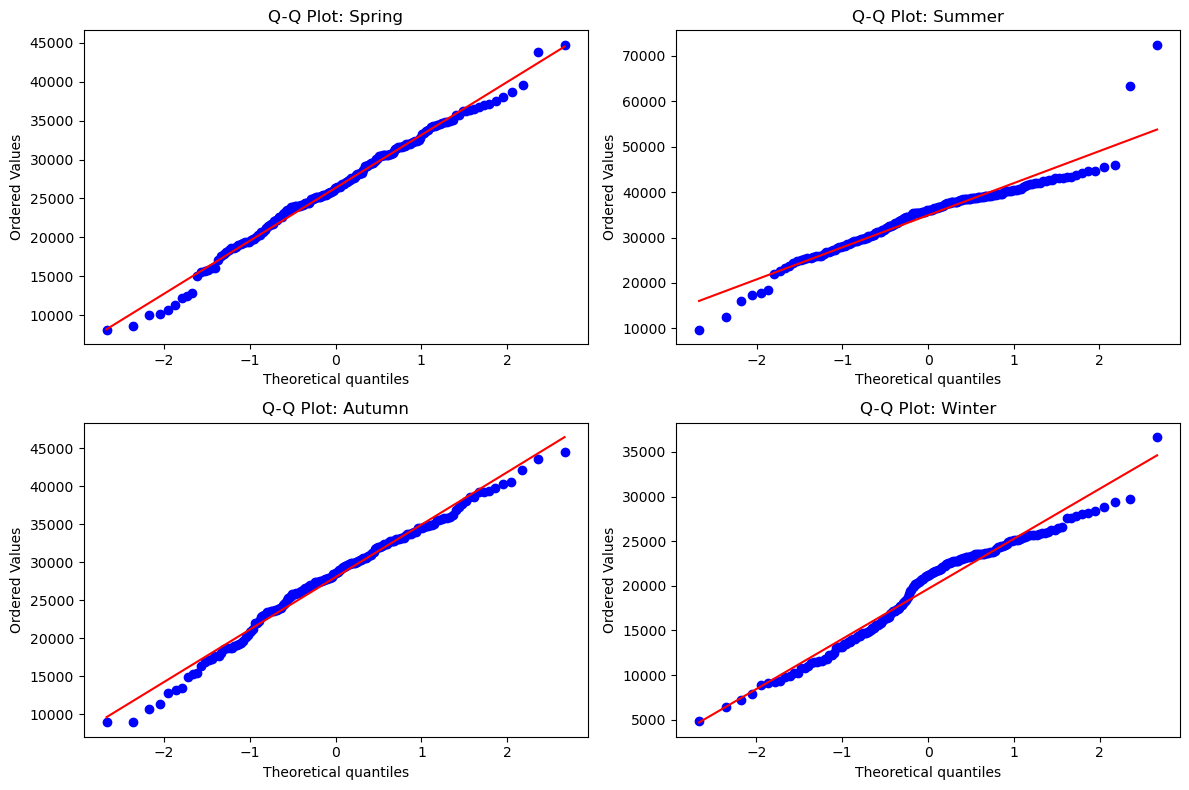

In [44]:
# create new column with transformed 'time' column to show only dates without time
bikes['day'] = pd.to_datetime(bikes['time']).dt.date

# aggregate by day and season, sum daily bike rides
daily_rides = bikes.groupby(['day', 'season'])['count'].sum().reset_index()

# create data series for each season
spring_series = daily_rides[daily_rides['season'] == 'spring']['count']
summer_series = daily_rides[daily_rides['season'] == 'summer']['count']
autumn_series = daily_rides[daily_rides['season'] == 'autumn']['count']
winter_series = daily_rides[daily_rides['season'] == 'winter']['count']

# add lists with seasonal data (each in Series format) and season names
season_series = [spring_series, summer_series, autumn_series, winter_series]
season_names = ['spring', 'summer', 'autumn', 'winter']

# set a plot size
plt.figure(figsize=(12, 8))

# build Q-Q plot
for i, season in enumerate(season_series, 1):    # numeration from 1 for plt.subplot
    plt.subplot(2, 2, i)
    stats.probplot(season, dist="norm", plot=plt)    # create Q-Q plot - comparing distributions to normal
    plt.title(f'Q-Q Plot: {season_names[i - 1].capitalize()}')    # add title


plt.tight_layout()
plt.show()

***
**Interpretation**

The points of the Q-Q plots for autumn and spring fall roughly along the reference line, suggesting that the data is approximately normally distributed.

However, some deviations from the line are observed, especially in summer and winter groups, indicating possible outliers and change of the form. Outliers could be present in the summer group due to a seasonal peak in bike share demand in July, as shown in the "Bike Share Distribution by Months" graph.

**Business insight**
Extreme peaks(like July) could be driven by events or weather. Identifying these patterns helps improve forecasting accuracy and demand prediction.
***

To further assess the distributional shapes, histograms with KDE curves will be used.

C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

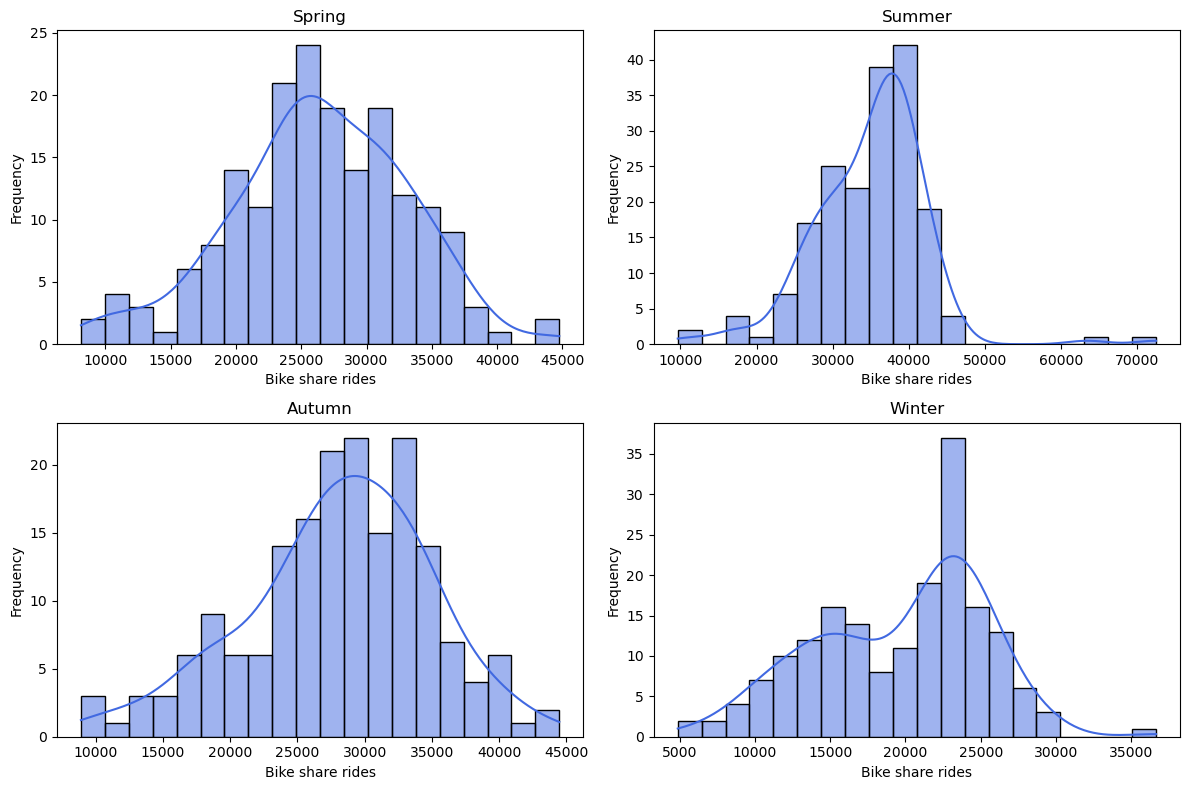

In [31]:
# set a plot size
plt.figure(figsize=(12, 8))

# build histograms with KDE to assess seasonal data distributions

for i, season in enumerate(season_series, 1):
    plt.subplot(2, 2, i)
    sns.histplot(season, kde=True, label=season_names[i - 1], element='bars', bins = 20, color = 'royalblue')
    plt.title(season_names[i - 1].capitalize(), fontsize=12)
    plt.xlabel("Bike share rides")
    plt.ylabel("Frequency")
    
plt.tight_layout()
plt.show()

***
**Interpretation**

The histograms support the conclusions drawn  from the Q-Q plots regarding deviations from normality in the summer and winter distributions. Both summer and winter show signs of outliers, with winter also exhibiting a second, less prominent peak. In contrast, autumn and spring distributions are approximately normal, with only a few individual deviations.


**Business insight**

Irregular patterns in winter/summer suggest that bike usage is more volatile in extreme temperatures. Business models may need to be more flexible during these months.
***

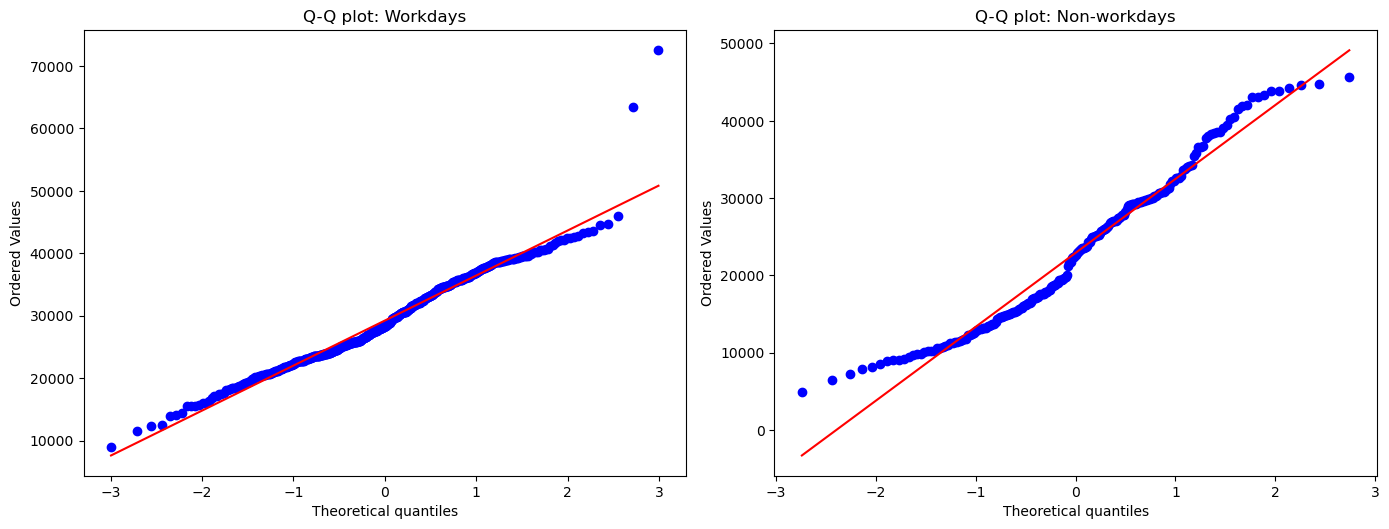

In [45]:
# aggregate by day and day types, sum daily bike rides
daily_rides_w = bikes.groupby(['day', 'is_holiday', 'is_weekend'])['count'].sum().reset_index()

# create day types data series
workdays_series = daily_rides_w[(daily_rides_w['is_weekend'] == 0) & (daily_rides_w['is_holiday'] == 0)]['count']
non_workdays_series = daily_rides_w[(daily_rides_w['is_weekend'] == 1) | (daily_rides_w['is_holiday'] == 1)]['count']

# set a plot size
plt.figure(figsize=(14, 10))

# build Q-Q plots
plt.subplot(2, 2, 1)   
stats.probplot(workdays_series, dist="norm", plot=plt)
plt.title("Q-Q plot: Workdays")

plt.subplot(2, 2, 2)   
stats.probplot(non_workdays_series, dist="norm", plot=plt)
plt.title("Q-Q plot: Non-workdays")


plt.tight_layout()
plt.show()

***
**Interpretation**

The Q-Q plot for **workdays** show that most points fall roughly along the reference line, indicating an **approximately normal** distribution, though a few with a few high values appear in the upper tail. 

In contrast, the Q-Q plot for **non-workdays** shows more pronounced **deviations from normality**, with both tails located higher than expected and the points forming a noticeable S-shaped curve around the reference line.

**Business insight**

Non-workday demand is less predictable and may include more outliers due to events or variable leisure activities. Pricing models might benefit from weekend-specific tuning.
***

C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nadine\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


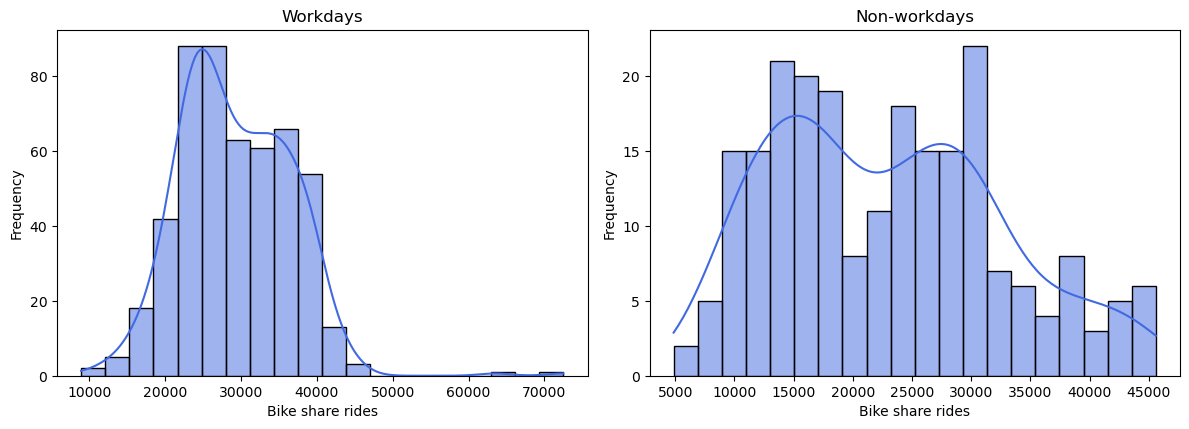

In [182]:
# set a plot size
plt.figure(figsize=(12, 8))

# build histograms with KDE to assess workday and non-workday distributions
plt.subplot(2, 2, 1)
sns.histplot(workdays_series, kde=True, element='bars', bins = 20, color = 'royalblue')
plt.title("Workdays", fontsize=12)
plt.xlabel("Bike share rides")
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
sns.histplot(non_workdays_series, kde=True, label="Non-workdays", element='bars', bins = 20, color = 'royalblue')
plt.title("Non-workdays", fontsize=12)
plt.xlabel("Bike share rides")
plt.ylabel("Frequency")
    
plt.tight_layout()
plt.show()

***
The Q-Q plot for workdays suggests that the distribution is approximately normal, with most points falling close to the reference line. However, the **histogram reveals** asymmetry and a plateau in the upper range of values, indicating a **deviation from  perfect normality** that is not clearly reflected in the Q-Q plot.

The histogram for non-workdays supports and highlights the deviations from normality observed in the Q-Q plot, showing signs of bimodality, asymmetry, and individual values that are higher than expected.


**Interpretation:**
- **Workdays**: Ride frequency is relatively stable and approximately normally distributed, with occasional outliers likely due to peak demand or external factors.
- **Non-Workdays**: Ride frequency shows greater variability, with signs of asymmetry, heavy tails, and potential bimodality. Data is less consistent, and non-normal models may better capture the distribution.


**Business insight:**
- The higher variability in non-workday behavior highlights the need for different predictive models or marketing strategies. Leisure users may respond to different stimuli than weekday commutes. 
***

## 5. Feature Engineering

To examine relationships between multiple quantitative variables, the data must meet the assumptions of Pearson’s correlation test. To achieve that we will transform the 'time' column.

### Encoding Hour of Day with Sine and Cosine

Time-based features like hour-of-day are **periodic** — after 23:00 comes 0:00, forming a loop. 
Using the raw hour (e.g., 0–23) in correlation or modeling treats time as **linear**, which can distort relationships and reduce predictive power.

To preserve the **cyclic nature** of time, we transform hour values into sine and cosine components.

This maps each hour onto a point on the **unit circle**, where midnight 0:00 and 23:00 are close together — as they are in reality. These transformed values can then be meaningfully used in correlations or predictive models.


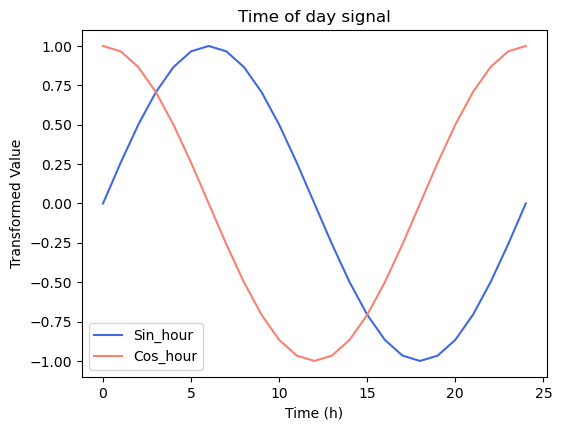

In [235]:
# set a plot size
plt.figure(figsize=(6, 4.5))

# transform hours to the daily cycles connection with bike rides
bikes['sin_hour'] = np.sin(2 * np.pi * bikes['hour'] / 24)
bikes['cos_hour'] = np.cos(2 * np.pi * bikes['hour'] / 24)

# transform the dates into days since start of the measurements to evaluate the main trend 
# on increasing/decreasing demand on bike rides with time
bikes['days_since_start'] = (bikes['time'] - bikes['time'].min()).dt.days

# visualize transformation of hours into cos and sin
plt.plot(np.array(bikes['sin_hour'])[:25], color='royalblue')
plt.plot(np.array(bikes['cos_hour'])[:25], color='salmon')
plt.xlabel('Time (h)')
plt.ylabel('Transformed Value')
plt.title('Time of day signal')
plt.legend(["Sin_hour", "Cos_hour"])

plt.show()

## 6. Statistical Analysis

### 6.1 Pearson correlation coefficient

Pearson correlation will be used to measure the **strength and direction of linear relationships** between **quantitative variables** in the dataset. This method is appropriate because it is well-suited for continuous, numeric data and provides an interpretable metric ranging from -1 to 1, indicating both the degree and direction of association.

In [184]:
# calculate correlations between numerical columns
# focus on the first row as it represents correlations with bike rides count
quantitative_columns = bikes[['count', 'temp_real_C', 'temp_feels_like_C', 
                    'humidity_percent', 'wind_speed_kph', 'days_since_start', 
                    'sin_hour', 'cos_hour']]
bikes_corr = quantitative_columns.dropna().corr().round(4)

bikes_corr

,count,temp_real_C,temp_feels_like_C,humidity_percent,wind_speed_kph,days_since_start,sin_hour,cos_hour
count,1.0000,0.3888,0.3690,-0.4629,0.1163,0.0396,-0.3216,-0.4775
temp_real_C,0.3888,1.0000,0.9883,-0.4478,0.1455,0.1315,-0.2131,-0.1899
temp_feels_like_C,0.3690,0.9883,1.0000,-0.4035,0.0884,0.1431,-0.1952,-0.1700
humidity_percent,-0.4629,-0.4478,-0.4035,1.0000,-0.2878,0.1199,0.3767,0.3421
wind_speed_kph,0.1163,0.1455,0.0884,-0.2878,1.0000,-0.1264,-0.1756,-0.2225
days_since_start,0.0396,0.1315,0.1431,0.1199,-0.1264,1.0000,-0.0007,0.0003
sin_hour,-0.3216,-0.2131,-0.1952,0.3767,-0.1756,-0.0007,1.0000,-0.0003
cos_hour,-0.4775,-0.1899,-0.1700,0.3421,-0.2225,0.0003,-0.0003,1.0000


In [200]:
# check the p-values for Pearson correlation test
# create results list
pearson_results_2 = []

# apply stats.pearsonr() to each quantitative column
for column in quantitative_columns:
    bikes_corr_2, p_value_pearson = stats.pearsonr(bikes['count'], bikes[column])
    pearson_results_2.append({'Variable': column, 'Pearson_r': bikes_corr_2, 'p_value': p_value_pearson})
    
# set index to the 'Variables' column
pearson_res_df = pd.DataFrame(pearson_results_2).set_index('Variable').rename_axis('Variable', axis = 'columns').rename_axis(None, axis='rows')
# round correlation results
pearson_res_df['Pearson_r'] = pearson_res_df['Pearson_r'].round(4)

print(pearson_res_df.sort_values(by = 'Pearson_r', ascending= False))

Variable           Pearson_r       p_value
count                 1.0000  0.000000e+00
temp_real_C           0.3888  0.000000e+00
temp_feels_like_C     0.3690  0.000000e+00
wind_speed_kph        0.1163  1.695106e-53
days_since_start      0.0396  1.778767e-07
sin_hour             -0.3216  0.000000e+00
humidity_percent     -0.4629  0.000000e+00
cos_hour             -0.4775  0.000000e+00


***
Optional: Spearman's correlations were computed as robustness check.
Results are available in the Appendix section.
***

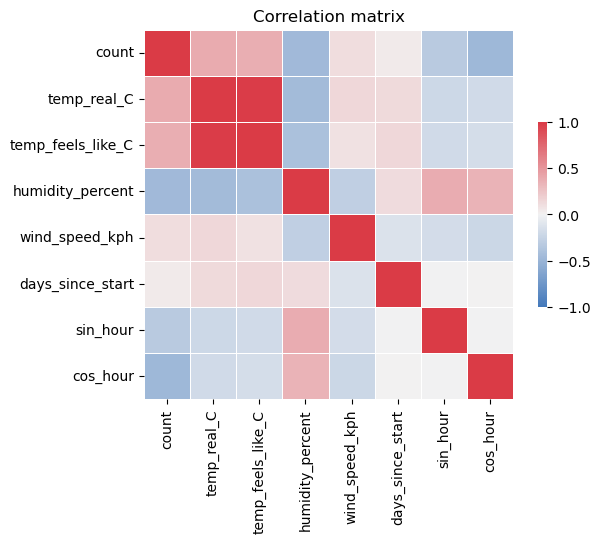

In [186]:
# create heatmap correlation matrix
colour_map = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(bikes_corr, cmap=colour_map, vmax=1.0, vmin=-1.0, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix')

plt.show()

#### Results

**The strongest correlations with bike rides are observed with cosine of hours, humidity and real temperature**.
  
 - Negative correlation is found with cosine of the hours (r = -0.48, p < 0.05). Further analysis of the cosine and sine of the hours will be conducted while separating data into working and non-working days.   
  
 - Moderate negative correlation with humidity (r = -0.46, p < 0.05) suggests that people tend to ride bikes more when the air is less humid.     
  
 - Moderate positive correlation with temperature (r = 0.39 , p < 0.05) may indicate that warmer weather encourages more ride bikes.

#### From Three to Two Day Types: Merging Holidays and Weekends into a Unified Group

Following exploratory analysis ("Hourly Bike Share Distribution by Day Types"), **holidays and weekends were found to show similar daily usage patterns**. As a result, they were merged into a single category: **'non-working days'**.

Rationale:
 - Holidays and weekends show **similar distribution shapes** with identical peak hours. 
 - The **holiday group contains significantly fewer observations** (384) compared to workdays (12,060) and weekends (4,970). This imbalance may lead to unreliable or non-representative results if holidays are analyzed as a separate group.

In [187]:
for name, group in bikes.groupby('is_workday'):
    corr_sin = group['count'].corr(group['sin_hour'])
    corr_cos = group['count'].corr(group['cos_hour'])
    print(
        f" { {0: 'Non-working days', 1: 'Working days'}.get(name, 'Unknown') }: \n"
        f" Correlation (count, sin_hour) = {corr_sin:.4f}\n"
        f" Correlation (count, cos_hour) = {corr_cos:.4f}\n"
)

 Non-working days: 
 Correlation (count, sin_hour) = -0.5160
 Correlation (count, cos_hour) = -0.5608

 Working days: 
 Correlation (count, sin_hour) = -0.2573
 Correlation (count, cos_hour) = -0.4549



#### Correlation Results for Sine and Cosine Encoded Hour-of-Day. Working and Non-working days
**Stronger correlation with non-working days.**
 - Non-working days show more cyclicity - perhaps because people ride bikes more evenly throughout the day on weekends and holidays which supported by the hourly distribution unimodality with a more even cycle (the graph "Hourly Bike Share Distribution by Day Types")
 - High negative correlation with cosine may indicate that peak activity on non-working days occurs in the afternoon, because cos(π) = -1 corresponds to 12:00 (Top hours for non-working days as shown earlier: 12-16)
  
  
**Weaker correlation on weekdays.**
 - On working days people may commute to work in the mornings and back in the evenings, which gives 2 peaks ("Hourly Bike Share Distribution by Day Types" graph, working days line) and more complex relatioship - this reduces the linear correlation.

**Comparison of sine and cosine.**
 - Cosine has overall stronger correlation, which may indicate that the differences between the night (00:00) and the daytime (12:00) are more pronounced than between the morning (6:00) and evening (18:00) peaks, to which the sine reacts more.


### 6.2 One-Way ANOVA

The connections between dependent variable (count) and independent quantitative variables were explored using correlation. 

The further analysis will be concentrated on **categorical variables**. Those are: seasons, weather conditions and day types (Workdays or Non-workdays). 

To assess seasonal differences, we will use One-Way ANOVA.

#### 6.2.1 Seasonal differences in bike rides
##### Evaluating ANOVA Assumptions

The key assumptions before applying the test:

 - The **normality** of the residuals in the groups. Will be assessed using visual analysis, **the Shapiro-Wilk test and  D’Agostino-Pearson test**.
 - Independence of observations is supported by the data set characteristics.
 - The homogeneity of the **variances** will be assessed using the **Levene test**.

In [188]:
# test the normality of seasonal data using Shapiro-Wilk and D’Agostino-Pearson methods
for name, season in zip(season_names, season_series):
    print(f"\nSeason: {name}")
    stat, p_shapiro = stats.shapiro(season)
    print(f"Shapiro-Wilk p-value: {p_shapiro:.4f}")
    stat2, p_dagostino = stats.normaltest(season)
    print(f"D’Agostino-Pearson p-value: {p_dagostino:.4f}")


Season: spring
Shapiro-Wilk p-value: 0.2695
D’Agostino-Pearson p-value: 0.3277

Season: summer
Shapiro-Wilk p-value: 0.0000
D’Agostino-Pearson p-value: 0.0000

Season: autumn
Shapiro-Wilk p-value: 0.0462
D’Agostino-Pearson p-value: 0.0715

Season: winter
Shapiro-Wilk p-value: 0.0002
D’Agostino-Pearson p-value: 0.0753


In [189]:
# apply Levene's test to assess the equality of variances
statistic, p_value = levene(spring_series, summer_series, autumn_series, winter_series)

print("Levene's test statistic:", statistic)
print("p-value:", p_value)

Levene's test statistic: 1.0357708840952315
p-value: 0.37604312644052884


##### Results of Assumption Testing for ANOVA

Although the distributions of two of the four groups (summer and winter, p-values < 0.05) deviated from normality, the ANOVA method is known for its robustness to moderate violations of this assumption, especially when the variances are equal.

The **homogeneity** of the variances was **confirmed** using the Levene test (p = 0.376), which allows us to consider the variances in the groups to have no statistical differences.

In [190]:
# evaluate the differences between seasons with one-way ANOVA

f_statistic, p_value_f = f_oneway(spring_series, summer_series, autumn_series, winter_series)

print("F-statistic:", f_statistic)
print("P-value:", p_value_f)

F-statistic: 160.05056008100559
P-value: 1.273028745009181e-79


##### ANOVA Results: Seasonal Differences

The p-value is less that 0.05, which indicates that there is a statistical **difference** among the **seasons** (p = 1.27 × 10$^{-79}$)

##### Post-hoc Analysis. Tukey’s Honestly Significant Difference Test 

The statistically significant difference between the groups found with ANOVA suggests that at least one group mean differs from the others.

Further post-hoc analysis will determine which seasons show significant differences.

In [191]:
# apply Tukey’s honestly significant difference test with scipy.stats.tukey_hsd() 
# to get pairwise comparison of means for seasons
results_tukey = tukey_hsd(spring_series, summer_series, autumn_series, winter_series)

print(results_tukey)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)  -8556.375     0.000-10352.894 -6759.856
 (0 - 2)  -1667.867     0.082 -3471.815   136.080
 (0 - 3)   6702.039     0.000  4898.092  8505.987
 (1 - 0)   8556.375     0.000  6759.856 10352.894
 (1 - 2)   6888.508     0.000  5084.560  8692.455
 (1 - 3)  15258.414     0.000 13454.467 17062.362
 (2 - 0)   1667.867     0.082  -136.080  3471.815
 (2 - 1)  -6888.508     0.000 -8692.455 -5084.560
 (2 - 3)   8369.906     0.000  6558.560 10181.252
 (3 - 0)  -6702.039     0.000 -8505.987 -4898.092
 (3 - 1) -15258.414     0.000-17062.362-13454.467
 (3 - 2)  -8369.906     0.000-10181.252 -6558.560



##### Results of Tukey’s Test

 - There is **no statistical difference between spring and autumn** in bike share rides (p = 0.082).

 - P-values between other seasons are less that 0.05, which indicates that there are statistically significant differences among all the other pairs of seasons.

####  6.2.2 Bike Ride Differences by Day Type (Working vs. Non-working)
##### Evaluating ANOVA Assumptions
Before assessing the differences between working and non-working days the assumptions of ANOVA will be tested.

In [192]:
# test the normality of data for workdays and non-workdays using Shapiro-Wilk and D’Agostino-Pearson methods
print(f"\nWorkdays")
stat, p_shapiro = stats.shapiro(workdays_series)
print(f"Shapiro-Wilk p-value: {p_shapiro}")
stat2, p_dagostino = stats.normaltest(workdays_series)
print(f"D’Agostino-Pearson p-value: {p_dagostino}")

print(f"\nNon-workdays")
stat, p_shapiro = stats.shapiro(non_workdays_series)
print(f"Shapiro-Wilk p-value: {p_shapiro}")
stat2, p_dagostino = stats.normaltest(non_workdays_series)
print(f"D’Agostino-Pearson p-value: {p_dagostino}")


Workdays
Shapiro-Wilk p-value: 2.5080271193189674e-09
D’Agostino-Pearson p-value: 3.927965072439569e-13

Non-workdays
Shapiro-Wilk p-value: 1.973451071535237e-05
D’Agostino-Pearson p-value: 0.0006367063871376003


In [193]:
# apply Levene's test to assess the equality of variances
statistic_d, p_value_d = levene(workdays_series, non_workdays_series)

print("Levene's test statistic:", statistic_d)
print("p-value:", p_value_d)

Levene's test statistic: 35.89675250219346
p-value: 3.270345504741337e-09


##### Results of Assumption Testing for ANOVA

Shapiro-Wilk and D’Agostino-Pearson tests indicated that the data significantly deviates from normality (Workdays: p = 2.51 × 10$^{-9}$, p = 3.93 × 10$^{-13}$; Non-workdays: p = 1.97 × 10$^{-5}$, p = 0.0006). Therefore, the assumption of normality is violated.

**Variances** of the groups are **not equal** according to Levene's test (p = 3.27 × 10$^{-9}$) 

A **non-parametric alternative to ANOVA** was selected, as the assumptions of normality and homogeneity of variances were not met.

### 6.3 Mann-Whitney U Test: Bike Ride Differences by Day Type

In [194]:
stat_mann, p_value_mann = mannwhitneyu(workdays_series, non_workdays_series)

print("Mann-Whitney U test statistic:", stat_mann)
print("p-value:", p_value_mann)

Mann-Whitney U test statistic: 79286.5
p-value: 1.3177999063474308e-17


##### Results of Mann-Whitney U Test

We reject the null hypothesis.

The p-value is less that 0.05, which indicates that there is a statistical difference between working and non-working days (p = 1.32 × 10$^{-17}$)

### 6.4 Kruskal-Wallis Test: Bike Rides by Weather Condition

Given the evident non-normality shown by exploratory analysis (weather histograms), the Kruskal-Wallis test is appropriate for further analysis to compare the median ranks across groups, as a non-parametric method that does not assume normal distribution of the data and provides a robust alternative to ANOVA when the normality assumption is violated.

Assumptions for the Kruskal–Wallis test

- data groups are not normally distributed or skewed
- the variable of interest is grouped into two or more independent groups
- distributions of the groups should be similar in shape (supported by seasonal histograms with KDE)
- samples should be randomly selected and independent
- each group should contain at least 5 observations to ensure sufficient sample size.

Based on the dataset characteristics and exploratory visualizations, these assumptions appear to be reasonably satisfied.

In [195]:
bikes.weather.value_counts()

weather
Clear                  6150
Scattered clouds       4034
Broken clouds          3551
Rain                   2141
Cloudy                 1464
Heavy precipitation      74
Name: count, dtype: int64

In [196]:
# create data series for each weather
clear_series = bikes[bikes['weather'] == 'Clear']['count']
scattered_clouds_series = bikes[bikes['weather'] == 'Scattered clouds']['count']
broken_clouds_series = bikes[bikes['weather'] == 'Broken clouds']['count']
rain_series = bikes[bikes['weather'] == 'Rain']['count']
cloudy_series = bikes[bikes['weather'] == 'Cloudy']['count']
heavy_precip_series = bikes[bikes['weather'] == 'Heavy precipitation']['count']

# apply statistics to all weather series
kruskal_weather = stats.kruskal(spring_series, summer_series, autumn_series, winter_series)
kruskal_weather

KruskalResult(statistic=310.7375553727569, pvalue=4.7176429046182367e-67)

##### Results of Kruskal-Wallis Test

As the Kruskal–Wallis test returned a p-value of ≈ 4.72 × 10$^{-67}$(<0.05), we can reject the null hypothesis and conclude that there is a statistical difference among the weather groups.

##### Post-hoc Analysis: Dunn's Test with Holm Correction

The statistically **significant difference between the groups** suggests that at least one group median differs from the others. Next we will conduct post-hoc analysis using Dunn's test with the Holm correction (has greater statistical power than the Bonferroni correction) to see which of the weather groups differed.

In [197]:
# apply Dunn's post-hoc test (Holm correction) to assess pairwise  weather group differences
dunn_p_values = sp.posthoc_dunn(bikes, val_col = 'count', group_col = 'weather', p_adjust='holm')

# round values to 4 decimal places and сenter all values in the Dunn's test results table
dunn_p_values.style.format(precision=4).set_properties(**{'text-align': 'center'})

,Broken clouds,Clear,Cloudy,Heavy precipitation,Rain,Scattered clouds
Broken clouds,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Clear,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Cloudy,0.0000,0.0000,1.0000,0.0001,0.0007,0.0000
Heavy precipitation,0.0000,0.0000,0.0001,1.0000,0.0000,0.0000
Rain,0.0000,0.0000,0.0007,0.0000,1.0000,0.0000
Scattered clouds,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [198]:
# generate a summary table with 'True' or 'False' based on whether p < 0.5
dunn_boolean = (dunn_p_values < 0.05)

# сenter all values in the boolean summary table
dunn_boolean.style.set_properties(**{'text-align': 'center'})

,Broken clouds,Clear,Cloudy,Heavy precipitation,Rain,Scattered clouds
Broken clouds,False,True,True,True,True,True
Clear,True,False,True,True,True,True
Cloudy,True,True,False,True,True,True
Heavy precipitation,True,True,True,False,True,True
Rain,True,True,True,True,False,True
Scattered clouds,True,True,True,True,True,False


##### Results of Dunn's Test
Post-hoc analysis using Dunn's test with Holm correction confirmed that **all pairwise comparisons** between weather conditions were statistically **significant** (p < 0.05).

This suggests that the distribution of bike rides varies meaningfully across all types of weather in the dataset.

## 7. Conclusion

In this analysis, the relationships between the number of bike share rides and various factors were explored using descriptive statistics, visualizations, correlation analysis, non-parametric tests, and analysis of variance.

**The key findings:**
- **Pearson correlation analysis** identified the strongest linear associations between bike ride count and **humidity, temperature**, and the **cosine** transformation of the `'hour'` variable.
    - A moderate **negative correlation with humidity** suggests that people tend to ride bikes more frequently when the air is less humid.
    - A moderate **positive correlation with temperature** indicates that warmer weather is assosiated with increased volume of bike share rides.
    - **Cyclic patterns** captured by the cosine and sine transformations of the `'hour'` variable were further explored by separating working and non-working days.
        - The strongest correlation was a **negative** one with the hour **cosine on non-working days**, suggesting a stronger cyclic pattern of bike rides during those days. This implies a more even distribution of rides throughout the day, which is also visually supported by the “Hourly Bike Share  Distribution by Day Types” chart, showing a unimodal, cyclic pattern for weekends and holidays.
- **One-Way ANOVA** revealed statistically significant differences in bike usage across **seasons**.
    - **Tukey’s post-hoc test** identified that all seasonal pairs showed significant differences in ride frequency, except for **spring-autumn** pair, which had comparable levels of activity. This suggests that biking behaviour in these two seasons is **similar**, while **summer and winter differ** more substantially.
- The **Mann-Whitney U test** confirmed that number of bike rides **differ** significantly between **workdays and non-working** days.
    - As shown in Table 1, working days exhibited two peaks – during morning (7:00-9:00) and evening (17:00-18:00) commute hours. In contrast, non-working days showed a single midday peak (12:00-16:00), aligning with differences in typical daily schedules.
- The **Kruskal-Wallis test** indicated significant **differences** in bike ride count across various weather conditions.
    - **Dunn's post-hoc test** revealed that these differences were statistically significant across **all pairs** of weather categories, suggesting that weather has a substantial impact on bike-sharing activity.
    
**Additional findings from descriptive and exploratory data analysis:**
- **Descriptive statistics** suggested a right-skewed distribution of the ride `'count'` variable, which was confirmed through the “Bike Share Rides Distribution” chart. Although the distribution deviated from normality, visual exploration of **pairwise distributions** (e.g. `'count'` vs temperature/humidity) − based on distribution plots − showed approximately normal patterns. This, along with assumption testing, supported the use of **parametric methods** such as ANOVA and Pearson correlation, alongside non-parametric tests. To ensure robustness, Spearman’s rank correlations were also calculated in addition to Pearson’s (see Appendix).
- As shown in the “Hourly Bike Share Distribution by Season” chart, **hourly riding** patterns vary notably **by season**.
    - In **autumn and winter**, peak usage occurs in the **morning** hours, while in **summer**, bike-sharing demand is highest in **evenings**.
    - In **spring**, morning and evening peak ride volumes are more **balanced**, potentially reflecting more stable daily routines.
- The “Bike Share Distribution by Month” chart reveals the **lowest demand in January** and the **highest in July**, reflecting a strong seasonal pattern.
- The "Hourly Bike Share Distribution by Day Types" chart reflects strong distinction between non-working days (weekends and holidays) and weekdays in bike ride volumes. Distribution for **workdays** is bimodal with peaks during **commute hours**. In contrast, **non-working** days show unimodality with **midday peak**.

**Business insights:** 

The following insights reflect how the analytical findings can support decision-making, resource allocation, and user strategy in bike-sharing business contex:
- **Weather and demand:** Warmer temperatures and lower humidity are associated with increased bike-sharing usage. However, unexpectedly high usage even in very humid conditions (75-90%) suggests the presence of consistent rider groups (e.g. commuters) less affected by discomfort. This implies that **full service** should be maintained during **humid conditions,** and further **used segmentation** could help identify resilient rider groups.
- **Hourly patterns:** Strong commute peaks on workdays (7:00-9:00 and 17:00-19:00) and a unimodal midday peak on non-working days confirm distinct usage behaviors. Operators can **optimize bike availability**, pricing, and promotions by day type to match demand cycles more precisely.
- **Seasonal variation:** Clear differences in **hourly usage by season** — including higher morning use in winter/autumn and strong evening peaks in summer — suggests that **rider behavior shifts** with environmental and social rhythms. Seasonal adjustments to fleet balancing, marketing, or pricing models could enhance responsiveness.
- **Monthly and weather category trends:** Bike usage is **strongly seasonal**, peaking in July and dipping in January. Noticeable decrease in bike rides during bad weather conditions supports the use of weather-informed demand forecasting and indicates that service planning and maintenance should be aligned with seasonal lows.
- **Distribution patterns:** Subtle distribution features — such as a steady increase in ride count with wind speed followed by a slight dip — may reflect thresholds in rider comfort. These patterns  can be leveraged to **fine-tune** predictive models and improve operational efficiency.
- **Statistical tests confirm key differences** in ride frequency across seasons, day types and weather conditions. These validated trends support **targeted** operational strategies rather than uniform approaches.

<br>
<br>
<br>

***
#### Appendix: Robustness check (not included in main analysis)

Pearson’s correlation coefficient was used to assess the relationships between the numeric variables, as the dataset contains a large number of observations, and histograms for most variable pairs showed approximately normal distributions. 

However, since the dependent variable (`count`) itself is not normally distributed — and shows signs of right-skewness and possible bimodality — Spearman’s rank correlation was also calculated as a robustness check. 

Comparing both methods allows to evaluate whether the relationships are strictly linear or possibly monotonic but non-linear.

In [199]:
from scipy.stats import spearmanr
from IPython.display import display


spearman_results = []

# apply stats.pearsonr() to each quantitative column
for column in quantitative_columns:
    bikes_corr_3, p_value_spearman = stats.spearmanr(bikes['count'], bikes[column])
    spearman_results.append({'Variable': column, 'Spearman': bikes_corr_3, 'p_value': p_value_spearman})
    
# set index to the 'Variables' column
spearman_results = pd.DataFrame(spearman_results).set_index('Variable').rename_axis('Variable', axis = 'columns').rename_axis(None, axis='rows')
# round correlation results
spearman_results['Spearman'] = spearman_results['Spearman'].round(4)

# join Pearson's and Spearman's correlation coefficient results
comparison = spearman_results.join(
    pearson_res_df,
    lsuffix='_speaman', 
    rsuffix='_pearson'
).sort_values(by='Spearman', ascending=False)

display(comparison)

Variable,Spearman,p_value_speaman,Pearson_r,p_value_pearson
count,1.0000,0.000000e+00,1.0000,0.000000e+00
temp_real_C,0.3924,0.000000e+00,0.3888,0.000000e+00
temp_feels_like_C,0.3867,0.000000e+00,0.3690,0.000000e+00
wind_speed_kph,0.1814,9.220312e-129,0.1163,1.695106e-53
days_since_start,0.0353,3.169942e-06,0.0396,1.778767e-07
sin_hour,-0.4214,0.000000e+00,-0.3216,0.000000e+00
humidity_percent,-0.5046,0.000000e+00,-0.4629,0.000000e+00
cos_hour,-0.5971,0.000000e+00,-0.4775,0.000000e+00


Although Pearson's coefficient was primarily used to assess linear relationships, Spearman's rank correlation was also calculated to account for possible non-linearity or outliers. 

The results were **generally consistent**, with some moderate differences observed for cyclical variables and wind speed (Δ ≈ 0.10–0.12), suggesting possible non-linear components in these relationships.